# Research Topics :  Predicting Solar Radiation


### Load Data

(NB this analysis was conducted locally so apologies for any odd formatting due to upload)

The first step is to load in the data and have a quick look at the dataset and the structure of the data to be predicted.

## Import Necessary Library

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
from sklearn import linear_model

%matplotlib inline

## Import Dataset

In [2]:
# import data
data = pd.read_csv('F:\Thesis Work\Project File\Solar Radiation\Dataset\SolarPrediction.csv')

# read few lines
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


## Ascending Dataset

In [3]:
# time is in reverse order, therefore order ascending
data = data.sort_values(by='UNIXTime', ascending=True).reset_index(drop=True)
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
1,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
2,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
3,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
4,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [4]:
# set Hawaii tz
HItz = pytz.timezone(zone='US/Hawaii')

# create a column which is type datetime
datetimeHI = data['UNIXTime'].apply(lambda x: 
                                 datetime.datetime.utcfromtimestamp(x).replace(tzinfo=pytz.utc).astimezone(HItz))
# add to df
data['DatetimeHI'] = datetimeHI

## Explotrary Data Analysis - EDA

C:\Users\imsanjoykb\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


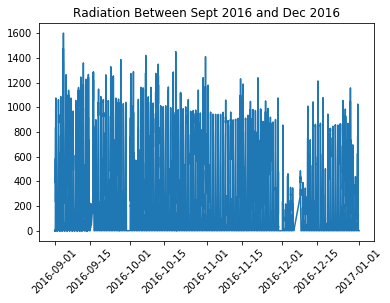

In [5]:
# show data to predict
plt.plot(data['DatetimeHI'], data['Radiation'])
plt.title('Radiation Between Sept 2016 and Dec 2016')
plt.xticks(rotation=45);

##### Preliminary Thoughts

* There appear to be daily spikes, might consider a micro- and a macro- model
* Something odd is happening late nov, early Dec, should be looked into. Missing data? Thanksgiving? Weather patterns?
* Need to think about how to split into training and testing data: take random days? block off December? 

### One Week Analysis

From very basic data analysis it appears that there is some sort of oscillating pattern on a more micro level. To investigate this, we will take the first week of the data and explore.

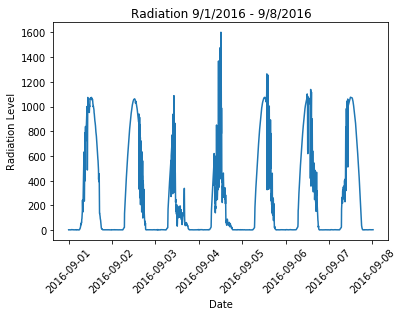

In [6]:
# extract one week of data
weekendmarker = datetime.datetime(2016,9, 8).replace(tzinfo=HItz)
weekonedata = data[data['DatetimeHI'] < weekendmarker]
plt.plot(weekonedata['DatetimeHI'], weekonedata['Radiation'])
plt.title('Radiation 9/1/2016 - 9/8/2016')
plt.xticks(rotation=45)
plt.ylabel('Radiation Level')
plt.xlabel('Date');

So definitely there is definitely a daily spike. Will be interesting to see if any smoothing functions need to be used.

Also, it appears that whatever the final model is, there should be an indicator variable governing whether the sun is up or not as, in hours of darkness solar radiation drops off.

We need to see how the other variables evolve over week:

In [7]:
def abstract_week_plot(ax, dates, col, colname):
    # function to take in column of data and plot the
    # week's worth of data
    # returns an axis so can be added to a larger plot
    
    # color radiation so it is easy to identify as the dependent var
    if colname == 'Radiation':
        plt_color = 'red'
    else:
        plt_color = 'blue'
    
    # plot the data
    ax.plot(dates, col, c=plt_color)
    
    # format
    ax.set_title('{colname} 9/1/2016 - 9/8/2016'.format(colname=colname))
    ax.set_ylabel('{colname} Level'.format(colname=colname))
    ax.set_xlabel('Date')
    
    # rotation
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    return ax

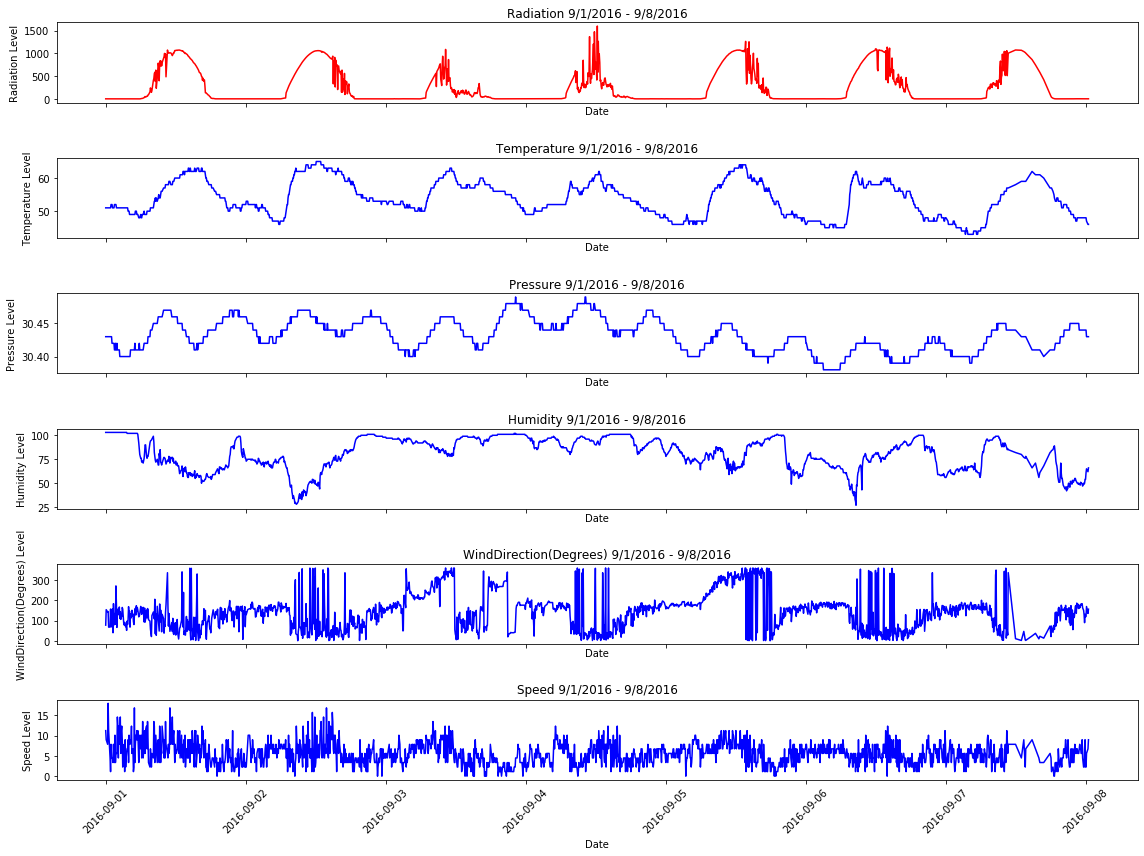

In [8]:
# make plot larger
plt.rcParams['figure.figsize'] = 16, 12

# loop over all columns important in data
ts_cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
fig, axes = plt.subplots(len(ts_cols), sharex=True)
for i, ax in enumerate(axes):
    ax = abstract_week_plot(ax, weekonedata['DatetimeHI'], weekonedata[ts_cols[i]], ts_cols[i])

# prevent squashing
fig.tight_layout()

From the above graphs, the following can be seen:

* Temperature and Radiation have a very close connection. Oscillations appear to be quite in step. 
* The volatility of wind direction could have something to do with the spikes in radiaton.
* Pressure is also cyclic but has a different period than radiation.
* Speed and Humidity appear to be noisy but there could be something lurking there!

### Anomalous Radiation Investigation

Looking at the plot of radiation through the dataset, there appears to be a period of time where data is missing and around which the level of radiation appears to be very small indeed. We will now look at this perdiod in greater depth. To do this we will expand the functionality of our week plot for time series.

In [9]:
def abstract_subsection_plot(ax, data, colname, start_dt, end_dt):
    # function to take in column of data and plot the
    # week's worth of data
    # returns an axis so can be added to a larger plot
    
    # subset the data
    subset_data = data[(data['DatetimeHI'] > start_dt) & (data['DatetimeHI'] < end_dt)]
    dates = subset_data['DatetimeHI']
    col = subset_data[colname]
    
    # turn start date and end date into strings
    srt = start_dt.strftime('%m/%d/%Y')
    end = end_dt.strftime('%m/%d/%Y')
    
    # color radiation so it is easy to identify as the dependent var
    if colname == 'Radiation':
        plt_color = 'red'
    else:
        plt_color = 'blue'
    
    # plot the data
    ax.plot(dates, col, c=plt_color)
    
    # format
    ax.set_title('{colname} {srt} - {end}'.format(colname=colname, srt=srt, end=end))
    ax.set_ylabel('{colname} Level'.format(colname=colname))
    ax.set_xlabel('Date')
    
    # rotation
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    return ax

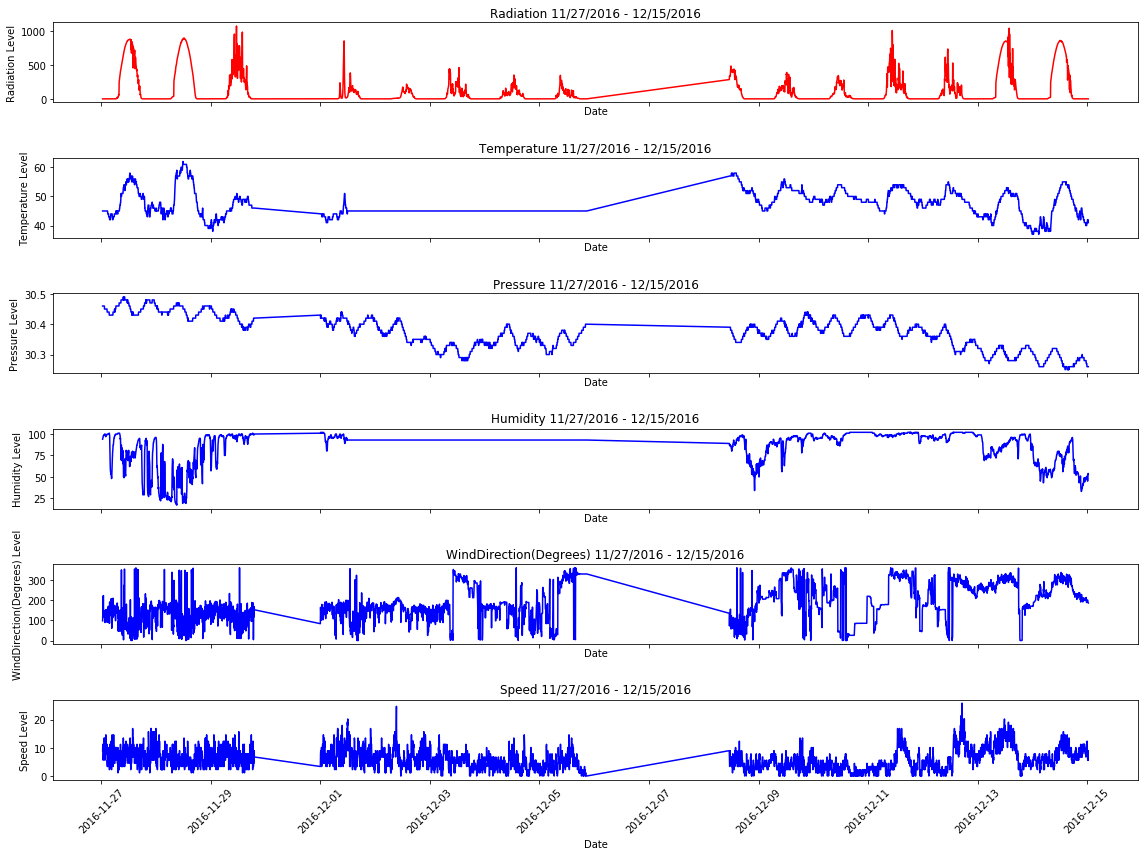

In [10]:
# loop over all columns important in data
fig, axes = plt.subplots(len(ts_cols), sharex=True)
for i, ax in enumerate(axes):
    ax = abstract_subsection_plot(
        ax,
        data,
        ts_cols[i],
        datetime.datetime(2016,11, 27).replace(tzinfo=HItz),
        datetime.datetime(2016,12, 15).replace(tzinfo=HItz),
    )
# prevent squashing
fig.tight_layout()

It appears that the data between November 29th and December 9th has been corrupted in some way and there is a certain amount of missing data here:

* There appears to be missing data between the end of Nov 29th and the start of Dec 1st and the end of Dec 5th and the middle of Dec 8th: no measurements for any fields.
* There appears to be holes in the temperature and humidity datasets between Nov 29th and the middle of Dec 8th. 

So, we have some missing data. The next step is to decide what to do with this. We could perform some sort of imputation in these dates. However, I would argue that because the behaviour of the dependent variable (the radiation) is abnormally small between these dates, there is something interesting going on here and I would not want to impute using values using data from times that do not reflect this abnormality in radiation.

Therefore, I will drop the dates between Nov 29th and Dec 8th from the dataset. Given this gap in data, I will then use Dec 8th to Dec 31st as my testing data and the data from Sep 1st to Nov 29th as my training data.

There are another two points that I will further investigate as well that show up as odd blips in the full plot from the first section of this notebook.

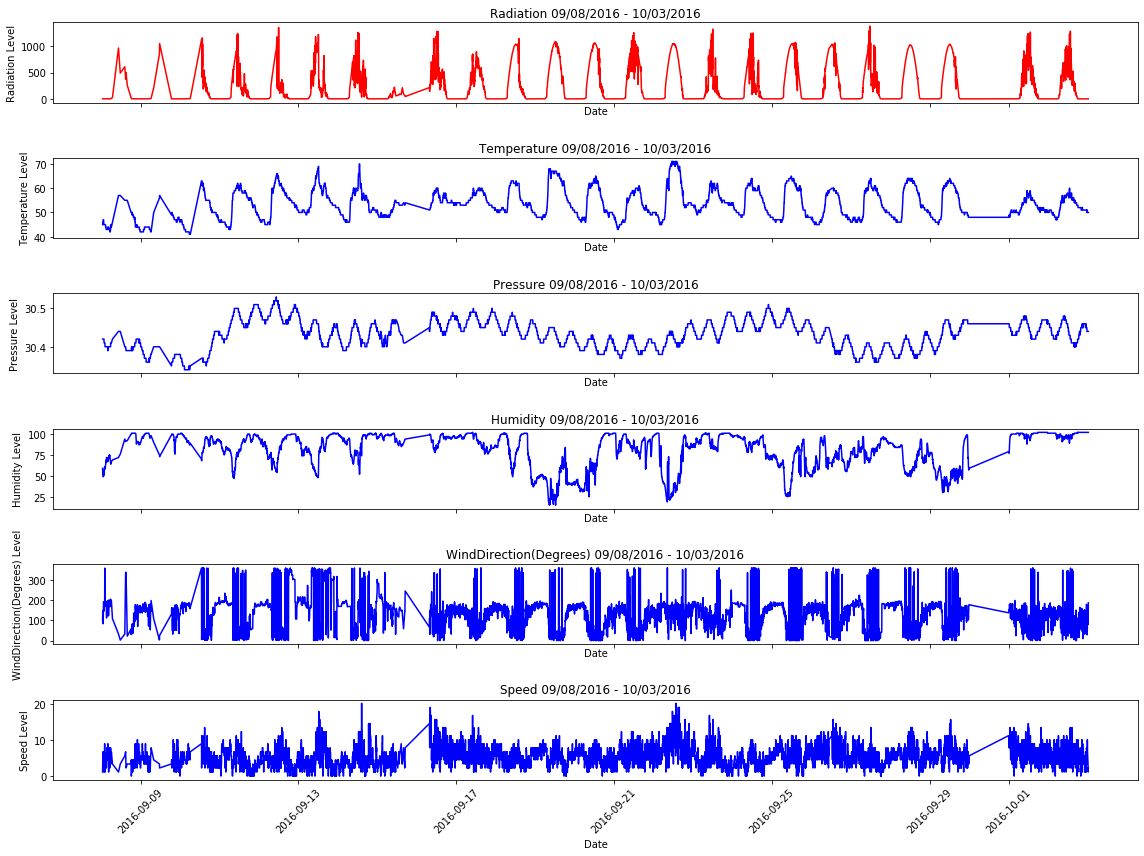

In [11]:
# loop over all columns important in data
fig, axes = plt.subplots(len(ts_cols), sharex=True)
for i, ax in enumerate(axes):
    ax = abstract_subsection_plot(
        ax,
        data,
        ts_cols[i],
        datetime.datetime(2016,9, 8).replace(tzinfo=HItz),
        datetime.datetime(2016,10, 3).replace(tzinfo=HItz),
    )
# prevent squashing
fig.tight_layout()

Unlike the graphs in late November the "flat spots" that occur here occur in all data columns at the same time. Therefore, they do not need to be dealt with. They appear flat here as matplotlib places these on a timeline. Therefore, our cutoffs from above hold.

In [12]:
start_train = datetime.datetime(2016, 9, 1).replace(tzinfo=HItz)
end_train = datetime.datetime(2016,11, 29).replace(tzinfo=HItz)
start_test = datetime.datetime(2016,12, 9).replace(tzinfo=HItz)
end_test = datetime.datetime(2016,12, 31).replace(tzinfo=HItz)

#### Adding Variables

Now that the graphs above have been investigated, it will be important to add some variables derived from the ones given here. This is because there might be missing some signal by just using the observed characteristics. 

As one of the models I plan on using is a regression, if a variable is omitted, this has a profound affected on the bias and of the regression coefficients.

##### Day

An indicator variable. 1 if the measurement is within the hours of daylight. 0 otherwise.

In [13]:
def is_day(row):
    sun_rise = datetime.datetime.strptime(row['TimeSunRise'], '%H:%M:%S').time()
    sun_set = datetime.datetime.strptime(row['TimeSunSet'], '%H:%M:%S').time()
    if ((sun_set > row['DatetimeHI'].time()) & (sun_rise < row['DatetimeHI'].time())):
        return 1
    else:
        return 0
    
day_bool = np.empty(data.shape[0])

for i in np.arange(data.shape[0]):
    day_bool[i] = is_day(data.iloc[i])

In [14]:
day_bool

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
data['Day'] = day_bool

In [16]:
# add interaction terms for Day
data['Day x Temperature'] = data['Temperature'] * day_bool
data['Day x Pressure'] = data['Pressure'] * day_bool
data['Day x Humidity'] = data['Humidity'] * day_bool
data['Day x WindDirection(Degrees)'] = data['WindDirection(Degrees)'] * day_bool
data['Day x Speed'] = data['Speed'] * day_bool

In [17]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,DatetimeHI,Day,Day x Temperature,Day x Pressure,Day x Humidity,Day x WindDirection(Degrees),Day x Speed
0,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 00:00:08-10:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 00:05:10-10:00,0.0,0.0,0.0,0.0,0.0,0.0
2,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 00:20:06-10:00,0.0,0.0,0.0,0.0,0.0,0.0
3,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 00:25:05-10:00,0.0,0.0,0.0,0.0,0.0,0.0
4,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 00:30:09-10:00,0.0,0.0,0.0,0.0,0.0,0.0


##### Hour of Day

As spikes occur every day, the hour of the day should be a useful metric. We are going to enhance this a little by using hours since sunrise.

In [18]:
from datetime import timedelta
import time

# create a series of number of hours since sunrise
# if not Day, then 0
hour_of_day = np.empty((data.shape[0], ))

for ix in data.index:
    # sunrise, sunset; probably a fiddler on the roof joke in there somewhere
    sr = datetime.datetime.strptime(data.loc[ix, 'TimeSunRise'], '%H:%M:%S').replace(tzinfo=HItz)
    ss = datetime.datetime.strptime(data.loc[ix, 'TimeSunSet'], '%H:%M:%S').replace(tzinfo=HItz)
    
    # if night, 0
    if ((data.loc[ix, 'DatetimeHI'].time() > ss.time()) | (data.loc[ix, 'DatetimeHI'].time() < sr.time())):
        hour_of_day[ix] = 0.
    else:
        time_ix = data.loc[ix, 'DatetimeHI'].time()
    
        # need to account for minutes
        # sunrise of 6:59 and time of 7:01 is closer to 0 hours apart than 1
        if (time_ix.hour - sr.hour > 0) & (time_ix.minute - sr.minute < 30):
            hour_of_day[ix] = time_ix.hour - sr.hour - 1
        else:
            hour_of_day[ix] = time_ix.hour - sr.hour

In [19]:
hour_of_day

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
from scipy import stats
stats.describe(hour_of_day)

DescribeResult(nobs=32686, minmax=(0.0, 11.0), mean=2.3429602888086642, variance=11.202062571897047, skewness=1.1254829544790657, kurtosis=-0.20023522846190556)

In [21]:
# have a look at dataframe to add
pd.get_dummies(hour_of_day).head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# add this to the full data frame
data = pd.concat([data, pd.get_dummies(hour_of_day)], axis=1)

## Model Building

Now that we have done some basic data visualization, cleaning and added some possible new predictors. We will now begin to build models.

We will train and tune a linear regression model to use as a baseline.

All metrics/visualizations are the OOS results

In [23]:
TRAIN = data[(data['DatetimeHI'] > start_train) & (data['DatetimeHI'] < end_train)]
TEST = data[(data['DatetimeHI'] > start_test) & (data['DatetimeHI'] < end_test)]

In [24]:
# split training and testing into X and y for compatibility with sklearn
X_train = TRAIN.drop(['UNIXTime', 'Data', 'Time', 'Radiation', 'TimeSunRise', 'TimeSunSet', 'DatetimeHI'], axis=1)
X_test = TEST.drop(['UNIXTime', 'Data', 'Time', 'Radiation', 'TimeSunRise', 'TimeSunSet', 'DatetimeHI'], axis=1)
y_train = TRAIN['Radiation']
y_test = TEST['Radiation']

## Linear Regression Algorithm

In [25]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [26]:
lin_reg.score(X=X_test, y=y_test)

0.6118643037648337

In [27]:
y_pred = lin_reg.predict(X_test)

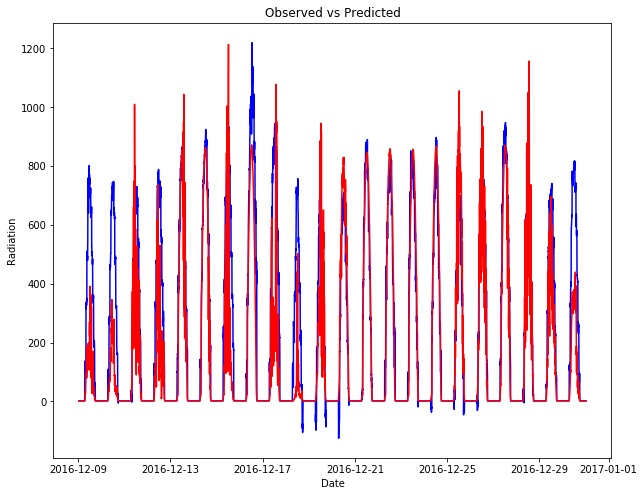

In [28]:
# resize
plt.rcParams['figure.figsize'] = 10, 8

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

Strip away the least important estimators:

In [29]:
# perform a backwards stepwise regression
from sklearn.feature_selection import RFE

# fit reduced model
reg = linear_model.LinearRegression()
reduced_reg = RFE(reg)
reduced_reg.fit(X_train, y_train)

RFE(estimator=LinearRegression())

In [30]:
reduced_reg.score(X=X_test, y=y_test)

0.5000362202123187

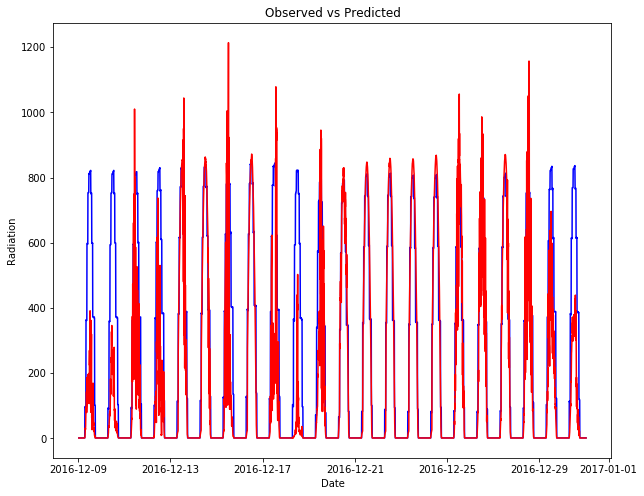

In [31]:
# predict using the reduced model
y_pred = reduced_reg.predict(X_test)

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

So this is as far as a linear regression will go. This gives us a baseline $R^2$ of 61.2% to build from with a more complicated model.

The most obvious thing that will need to be improved is the fact that negative radiation is impossible. Therefore, we will need a model that can deal with this. 

## Decision Tree Algorithm

In [32]:
from sklearn.tree import DecisionTreeRegressor as DTR

# fit random forest
dt = DTR()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [33]:
dt.score(X=X_test, y=y_test)

0.3995076167372923

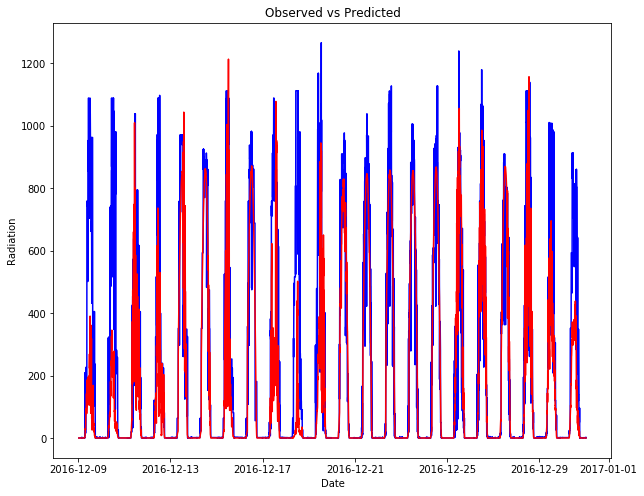

In [34]:
# predict using the random forest model
y_pred = dt.predict(X_test)

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

There seems to be a large amount of noise in this model, perhaps due to overfitting.

## Random Forest Algorithm

In [35]:
from sklearn.ensemble import RandomForestRegressor as RFR

# set seed for consistency
np.random.seed(171)

# fit random forest
random_forest = RFR()
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [36]:
random_forest.score(X=X_test, y=y_test)

0.6534398486927915

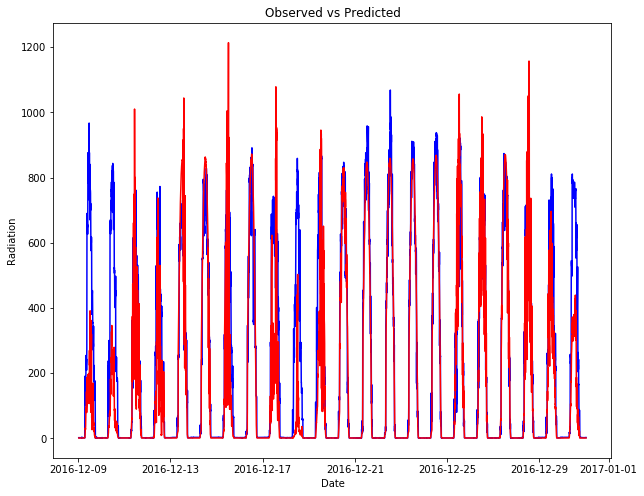

In [37]:
# predict using the random forest model
y_pred = random_forest.predict(X_test)

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

The random forest model has the advantage over the linear regression model as it does not return any negative predictions of radiation. Let us tune the model to see if the preformance can be boosted.

In [38]:
# depths to search
rf_depths = np.arange(5) + 1

# number of esimators to search
rf_estimators = np.linspace(1, 301, num=16)

In [39]:
rf_score_grid = np.empty((len(rf_depths), len(rf_estimators)))

# loop through sc
for i, depth in enumerate(rf_depths):
    for j, est in enumerate(rf_estimators):
        rf_ = RFR(max_depth=int(rf_depths[i]), n_estimators=int(rf_estimators[j]))
        rf_.fit(X_train, y_train)
        rf_score_grid[i, j] = rf_.score(X_test, y_test)

# display results
rf_score_grid

array([[0.41566218, 0.40752857, 0.4063999 , 0.40792411, 0.40783926,
        0.40737656, 0.40757282, 0.40710874, 0.40810387, 0.40788191,
        0.40807033, 0.40720469, 0.40743586, 0.40799786, 0.40778234,
        0.4076404 ],
       [0.53657483, 0.57661749, 0.58138694, 0.58500083, 0.58939989,
        0.58846346, 0.58401294, 0.58719021, 0.58306052, 0.58731386,
        0.58629394, 0.58523035, 0.58669699, 0.58627487, 0.58373455,
        0.58433839],
       [0.61175797, 0.6348326 , 0.63641806, 0.63777433, 0.64142133,
        0.63847165, 0.63767967, 0.64004419, 0.63810065, 0.63831623,
        0.63806106, 0.63869871, 0.63956964, 0.63763155, 0.640807  ,
        0.64027374],
       [0.6762948 , 0.67643476, 0.66548374, 0.66377923, 0.67111384,
        0.66218631, 0.66374953, 0.6623438 , 0.6700388 , 0.6657282 ,
        0.66126271, 0.66572627, 0.67190634, 0.66775114, 0.6686632 ,
        0.66936341],
       [0.64506701, 0.69236203, 0.68705473, 0.68634746, 0.68305003,
        0.68981434, 0.68388882, 

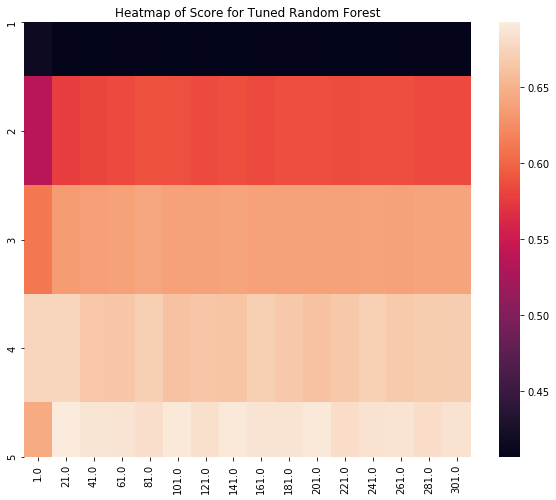

In [40]:
import seaborn as sns

# place in dataframe
rf_score_grid = pd.DataFrame(
    rf_score_grid,
    columns=[str(i) for i in rf_estimators],
    index=[str(i) for i in rf_depths]
)

# display as heatmap
sns.heatmap(rf_score_grid)
plt.title('Heatmap of Score for Tuned Random Forest');

In [41]:
rf_score_grid

,1.0,21.0,41.0,61.0,81.0,101.0,121.0,141.0,161.0,181.0,201.0,221.0,241.0,261.0,281.0,301.0
1,0.415662,0.407529,0.406400,0.407924,0.407839,0.407377,0.407573,0.407109,0.408104,0.407882,0.408070,0.407205,0.407436,0.407998,0.407782,0.407640
2,0.536575,0.576617,0.581387,0.585001,0.589400,0.588463,0.584013,0.587190,0.583061,0.587314,0.586294,0.585230,0.586697,0.586275,0.583735,0.584338
3,0.611758,0.634833,0.636418,0.637774,0.641421,0.638472,0.637680,0.640044,0.638101,0.638316,0.638061,0.638699,0.639570,0.637632,0.640807,0.640274
4,0.676295,0.676435,0.665484,0.663779,0.671114,0.662186,0.663750,0.662344,0.670039,0.665728,0.661263,0.665726,0.671906,0.667751,0.668663,0.669363
5,0.645067,0.692362,0.687055,0.686347,0.683050,0.689814,0.683889,0.689179,0.686606,0.686505,0.689437,0.681412,0.685361,0.686204,0.682156,0.684905


So, the maximum $R^2$ for the tuned random forest is 69.1% (`max_depth`=5, `n_estimators`=161). Let us now have a look at these predictions vs the observed values:

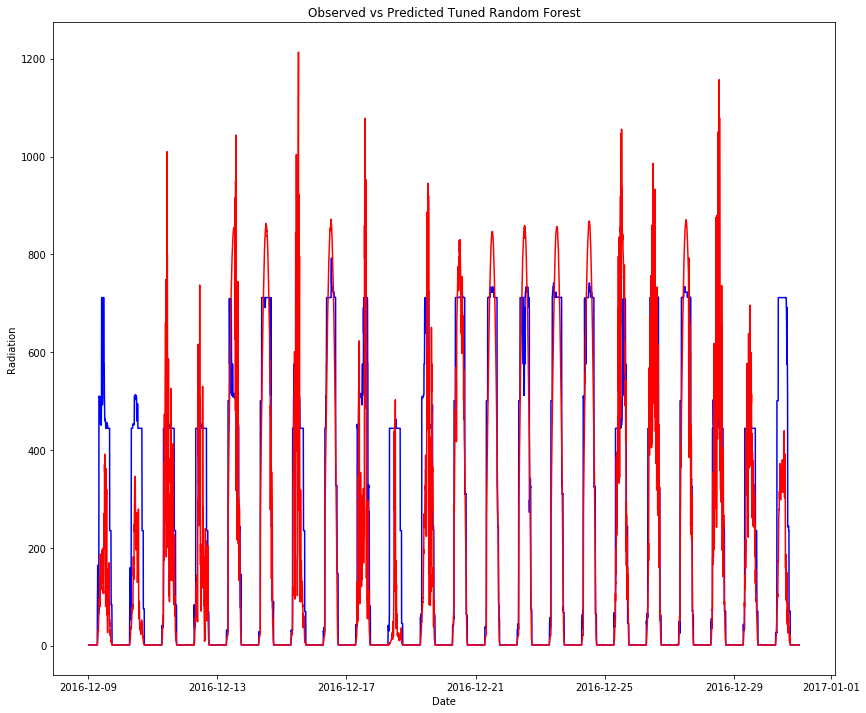

In [42]:
# predict using the tuned random forest model
rf = RFR(max_depth=5, n_estimators=161)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# resize
plt.rcParams['figure.figsize'] = 14, 12

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted Tuned Random Forest')
plt.ylabel('Radiation')
plt.xlabel('Date');

## Boosted Decision Tree Algorithm

In [43]:
from sklearn.ensemble import AdaBoostRegressor

# fit boosted tree
boosted_tree = AdaBoostRegressor(DTR(max_depth=3), n_estimators=200)
boosted_tree.fit(X_train, y_train)

# score
boosted_tree.score(X=X_test, y=y_test)

0.6499163709045314

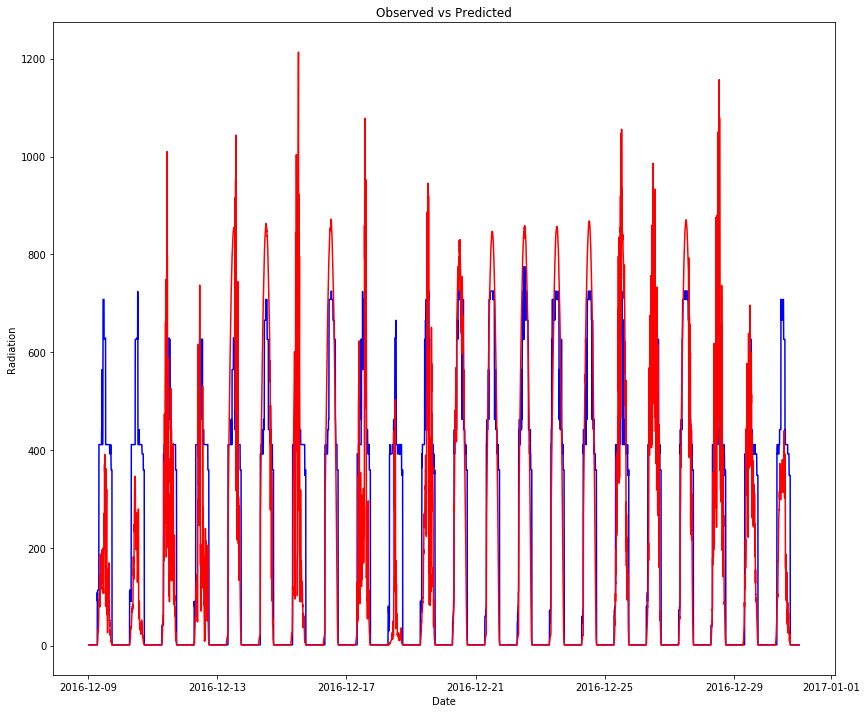

In [44]:
# predict using the random forest model
y_pred = boosted_tree.predict(X_test)

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

Let us try to tune the boosted decision tree now:

In [45]:
from tqdm import tqdm, trange

boost_depths = rf_depths 
boost_estimators = rf_estimators

boost_score_grid = np.empty((len(boost_depths), len(boost_estimators)))

# loop through sc ; tqdm will give a progress bar
for i, depth in enumerate(tqdm(boost_depths, total=len(boost_depths))):
    for j, est in enumerate(boost_estimators):
        boost_ = AdaBoostRegressor(DTR(max_depth=int(boost_depths[i])), n_estimators=int(boost_estimators[j]))
        boost_.fit(X_train, y_train)
        boost_score_grid[i, j] = boost_.score(X_test, y_test)

# display results
boost_score_grid

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.61s/it]


array([[0.40447423, 0.41775248, 0.38199444, 0.41234087, 0.38603297,
        0.39652347, 0.39470485, 0.39006751, 0.3824793 , 0.42427869,
        0.41344087, 0.42193326, 0.41836784, 0.38995323, 0.39209723,
        0.41846859],
       [0.55251402, 0.64217662, 0.64466899, 0.64947519, 0.62051825,
        0.62190854, 0.64936391, 0.60498899, 0.60384571, 0.64424187,
        0.6454592 , 0.61644438, 0.62267646, 0.60685364, 0.64707764,
        0.62595469],
       [0.6274306 , 0.65749941, 0.6385819 , 0.66156761, 0.65971849,
        0.65308919, 0.65839931, 0.64823337, 0.65960841, 0.65678213,
        0.65512811, 0.64586832, 0.65359477, 0.65464488, 0.65962218,
        0.63131021],
       [0.67122428, 0.68053067, 0.64847861, 0.66130163, 0.66792005,
        0.6622071 , 0.65727664, 0.65841191, 0.67368474, 0.66037807,
        0.64140782, 0.6736602 , 0.65934462, 0.67179775, 0.66279257,
        0.6505215 ],
       [0.68513399, 0.68480184, 0.68820048, 0.67205631, 0.67757897,
        0.67849506, 0.67820233, 

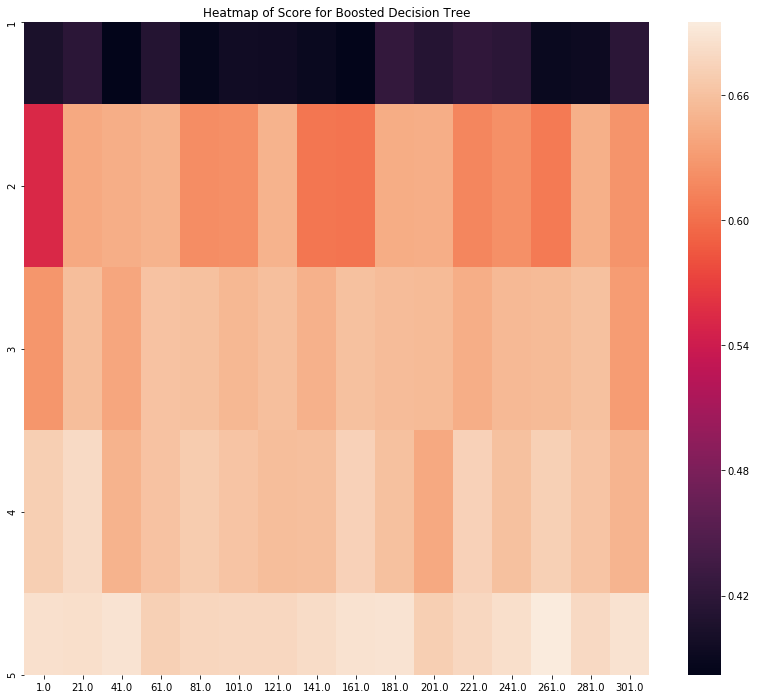

In [46]:
# place in dataframe
boost_score_grid = pd.DataFrame(
    boost_score_grid,
    columns=[str(i) for i in boost_estimators],
    index=[str(i) for i in boost_depths]
)

# display as heatmap
sns.heatmap(boost_score_grid)
plt.title('Heatmap of Score for Boosted Decision Tree');

The best fit here has an $R^2$ of 69.9%. Little bit more effective than the random forest. Let us have a look at this fit:

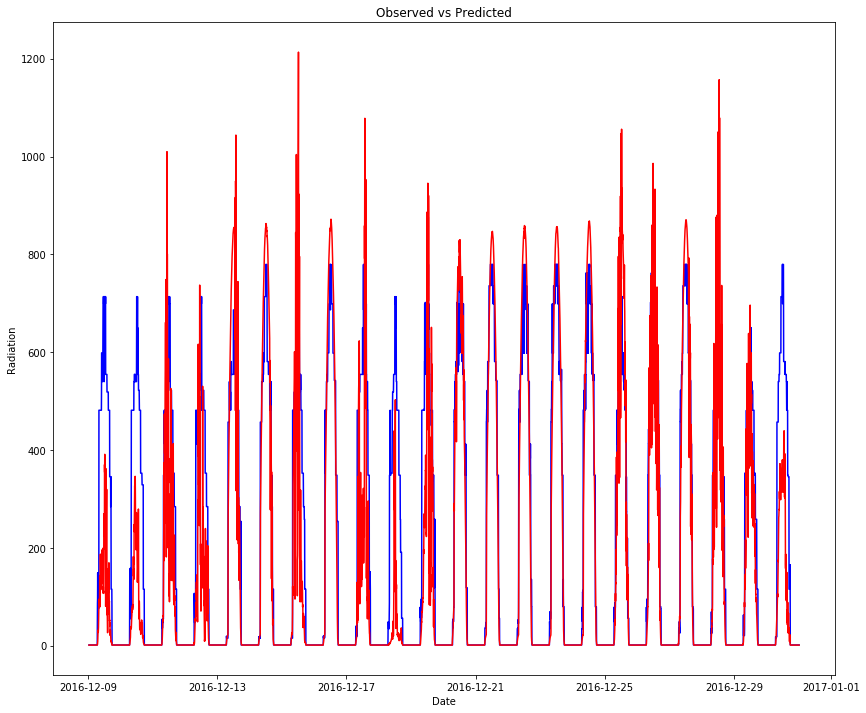

In [47]:
# predict using the boosted
bt = AdaBoostRegressor(DTR(max_depth=5), n_estimators=181)
bt.fit(X_train, y_train)
y_pred = bt.predict(X_test)

# plot results
plt.plot(TEST['DatetimeHI'], y_pred, c='blue', label='Predicted')
plt.plot(TEST['DatetimeHI'], y_test, c='red', label='Observed')
plt.title('Observed vs Predicted')
plt.ylabel('Radiation')
plt.xlabel('Date');

In [48]:
import pickle
pickle.dump(bt,open('model_solar_radiation.pkl','wb'))


In [49]:
model = pickle.load(open('model_solar_radiation.pkl','rb'))

Still, it looks like model is effective at gauging oscillation of the radiation, but not the extent of the peak. This is probably due to the fact that hour from sunrise is the most important predictor, leaving little variance due to the other independent variables. 

### Going Forward

For future iterations of this model I will seek to:
* Add more derived independent variables (variance of wind speed etc., many intraction terms)
* Perhaps use some smoothing functions
* More complicated models